![](img/330-banner.png)

# Lecture 15: Recommender systems

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("code/.")
import matplotlib.pyplot as plt
from plotting_functions import *
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

## Table of content

- [Learning outcomes](#lo)
- [Video 1: Motivation](#1)
- [Video 2: Formulating the recommendation problem](#2)
- [Video 3: Baseline approaches](#2)
- [Video 4: Collaborative filtering](#4)
- [Video 5: Summary and conclusion](#5)
- [Questions for class discussion](#questions)

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:
- State the problem of recommender systems. 
- Describe components of a utility matrix. 
- Create a utility matrix given ratings data. 
- Describe a common approach to evaluate recommender systems. 
- Implement some baseline approaches to complete the utility matrix. 
- Explain the idea of collaborative filtering. 
- Explain some serious consequences of recommendation systems. 

## Recommender systems motivation <a name="1"></a>

### What is a recommender system? 

- A recommender or a recommendation system **recommends** a particular product or service to users they are likely to consume. 

<img src="img/recommendation_system.png" alt="" height="900" width="900"> 


### Example: Recommender Systems
- A client goes to Amazon to buy products. 
- Amazon has some information about the client. They also have information about other clients buying similar products. 
- What should they recommend to the client, so that they buy more products? 
- There's no "right" answer (no label). 
- The whole idea is to understand user behavior in order to recommend them products they are likely to consume. 

### Why should we care about recommendation systems? 

- Almost everything we buy or consume today is in some way or the other influenced by recommendation systems. 
    - Music (Spotify), videos (YouTube), news, books and products (Amazon), movies (Netflix), jokes, restaurants, dating , friends (Facebook), professional connections (Linkedin)
- Recommendation systems are at the core of the success of many companies. 
    - Amazon
    - [Netflix](https://help.netflix.com/en/node/100639)


### An example Capstone project: [QxMD](https://qxmd.com/)

- Present personalized journal article recommendations to health care professionals.   

### What kind of data we need to build recommendation systems? 

- Customer purchase history data
- **User ratings data** (most common)
- **Features related to items or users** 

### Main approaches

- Collaborative filtering 
    - "Unsupervised" learning 
    - We only have labels $y_{ij}$ (rating of user $i$ for item $j$). 
    - We learn features.  
- Content-based recommenders 
    - Supervised learning
    - Extract features $x_i$ of users and/or items building a model to predict rating $y_i$ given $x_i$. 
    - Apply model to predict for new users/items. 
- Hybrid 
    - Combining collaborative filtering with content-based filtering
    

### The Netflix prize

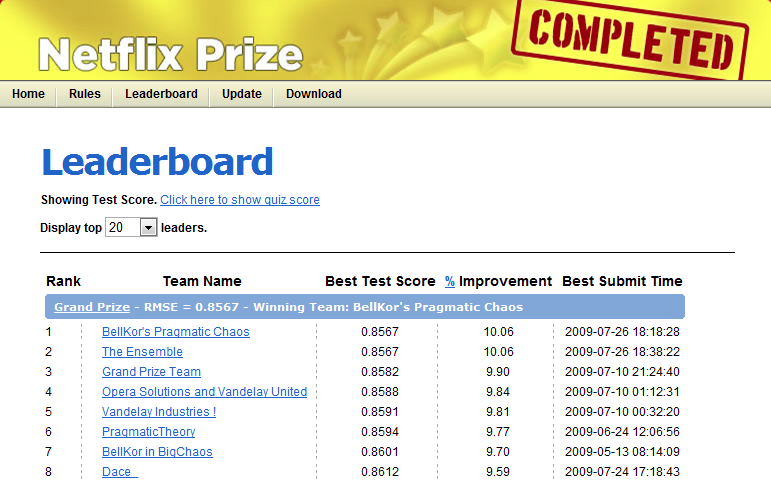

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

### The Netflix prize

- 100M ratings from 0.5M users on 18k movies.
- Grand prize was \$1M for first team to reduce squared error at least by 10%.
- Winning entry (and most entries) used collaborative filtering:
    - Methods that only looks at ratings, not features of movies/users.
- A simple collaborative filtering method that does really well:
   - "Regularized matrix factorization". Now adopted by many companies.

<br><br><br><br>

## Video 2: Recommender systems problem 

### Problem formulation

- Most often the data for recommender systems come in as **ratings** for a set of items from a set of users. 
- We have two entities: $N$ **users** and $M$ **items**. 
- **Users** are consumers. 
- **Items** are the products or services offered.  
    - E.g., movies (Netflix), books (Amazon), songs (spotify), people (tinder)  
    
<img src="img/utility_mat.png" alt="" height="900" width="900"> 


### Utility matrix 

- A **utility matrix** is the matrix that captures **interactions** between $N$ **users** and $M$ **items**. 
- The interaction may come in different forms: 
    - ratings, clicks, purchases
    
<img src="img/utility_mat.png" alt="" height="900" width="900"> 

### Utility matrix

- Below is a toy utility matrix. Here $N$ = 6 and $M$ = 5.  
- Each entry $y_{ij}$ ($i^{th}$ row and $j^{th}$ column) denotes the rating given by the user $i$ to item $j$. 
- We represent users in terms of items and items in terms of users. 

<img src="img/utility_mat.png" alt="" height="900" width="900"> 


### Sparsity of utility matrix

- The utility matrix is very sparse because usually users only interact with a few items. 
- For example: 
    - all Netflix users will have rated only a small percentage of content available on Netflix
    - all amazon clients will have rated only a small fraction of items among all items available on Amazon

### What do we predict? 
Given a utility matrix of $N$ users and $M$ items, **complete the utility matrix**. In other words, **predict missing values in the matrix**. 

<img src="img/utility_mat.png" alt="" height="900" width="900"> 


- Once we have predicted ratings, we can recommend items to users they are likely to rate higher. 

### Example dataset: [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset?select=jester_ratings.csv)

- We'll use a sample of [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset) to demonstrate different recommendation systems. 

The dataset comes with two CSVs
- A CSV containing ratings (-10.0 to +10.0) of 150 jokes from 59,132 users. 
- A CSV containing joke IDs and the actual text of jokes. 

> Some jokes might be offensive. Please do not look too much into the actual text data if you are sensitive to such language.

- Recommendation systems are most effective when you have a large amount of data.
- But we are only taking a sample here for speed.

In [2]:
filename = "data/jester_ratings.csv"
ratings_full = pd.read_csv(filename)
ratings = ratings_full[ratings_full["userId"] <= 4000]

In [3]:
ratings.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [4]:
user_key = "userId"
item_key = "jokeId"

### Dataset stats 

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141362 entries, 0 to 141361
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  141362 non-null  int64  
 1   jokeId  141362 non-null  int64  
 2   rating  141362 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.3 MB


In [6]:
def get_stats(ratings, item_key="jokeId", user_key="userId"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(ratings)

Number of ratings: 141362
Average rating:  1.200
Number of users (N): 3635
Number of items (M): 140
Fraction non-nan ratings: 0.278


### Creating utility matrix

- Let's construct utility matrix with `number of users` rows and `number of items` columns from the ratings data. 

> Note we are constructing a non-sparse matrix for demonstration purpose here. In real life it's recommended that you work with sparse matrices. 

In [7]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))


def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y


Y_mat = create_Y_from_ratings(ratings, N, M)
Y_mat.shape

(3635, 140)

### Utility matrix for the example problem
- Rows represent users.
- Columns represent items (jokes in our case).
- Each cell gives the rating given by the user to the corresponding joke. 
- Users are features for jokes and jokes are features for users.
- We want to predict the missing entries. 

In [8]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,NaN,-9.812,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3631,NaN,-9.844,7.531,-9.719,-9.344,3.875,9.812,8.938,8.375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,NaN,-1.906,3.969,-2.312,-0.344,-8.844,4.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3633,NaN,-8.875,-9.156,-9.156,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br><br><br>

## Video 3: Baseline Approaches


- Recall that our goal is to predict missing entries in the utility matrix. 

In [9]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,NaN,-9.812,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3631,NaN,-9.844,7.531,-9.719,-9.344,3.875,9.812,8.938,8.375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,NaN,-1.906,3.969,-2.312,-0.344,-8.844,4.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3633,NaN,-8.875,-9.156,-9.156,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Evaluation

- We'll try a number of methods to do this. 
- Although there is no notion of "accurate" recommendations, we need a way to evaluate our predictions so that we'll be able to compare different methods.
- Although we are doing unsupervised learning, we'll split the data and evaluate our predictions as follows.  

### Data splitting 

- We split the ratings into train and validation sets. 
- It's easier to split the ratings data instead of splitting the utility matrix.
- Don't worry about `y`; we're not really going to use it.  

In [10]:
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((113089, 3), (28273, 3))

Now we will create utility matrices for train and validation splits. 

In [11]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [12]:
train_mat.shape, valid_mat.shape

((3635, 140), (3635, 140))

- `train_mat` has only ratings from the train set and `valid_mat` has only ratings from the valid set.
- During training we assume that we do not have access to some of the available ratings. We predict these ratings and evaluate them against ratings in the validation set. 

### Questions for you

- How do train and validation utility matrices differ? 
- Why are utility matrices for train and validation sets are of the same shape?
<br><br>

**Answer:**

- The training matrix `train_mat` is of shape N by M but only has ratings from `X_train` and all other ratings missing. 
- The validation matrix `valid_mat` is also of shape N by M but it only has ratings `X_valid` and all other ratings missing. 
- They have the same shape because both have the same number of users and items; that's how we have constructed them. 

### Evaluation

- Now that we have train and validation sets, how do we evaluate our predictions?
- You can calculate the error between actual ratings and predicted ratings with metrics of your choice. 
    - Most common ones are MSE or RMSE. 

- The `error` function below calculates RMSE and `evaluate` function prints train and validation RMSE.  

In [13]:
def error(X1, X2):
    """
    Returns the root mean squared error.
    """
    return np.sqrt(np.nanmean((X1 - X2) ** 2))


def evaluate(pred_X, train_X, valid_X, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_X, train_X)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_X, valid_X)))

<br><br>

### Baselines

Let's first try some simple approaches to predict missing entries. 

1. Global average baseline
2. [$k$-Nearest Neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)    
    

### Global average baseline

- Let's examine RMSE of the global average baseline. 
- In this baseline we predict everything as the global average rating

In [14]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
1,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
2,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
3,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
4,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741


In [15]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 5.75
Global average valid RMSE: 5.77


### [$k$-nearest neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

- Can we try $k$-nearest neighbours type imputation? 
- Impute missing values using the mean value from $k$ nearest neighbours found in the training set. 
- Calculate distances between examples using features where neither value is missing. 

<img src="img/utility_mat.png" alt="" height="900" width="900"> 

In [16]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
train_mat_imp = imputer.fit_transform(train_mat)

In [17]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-1.6499,-4.9060,-2.7781,0.5530,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-2.0344,2.1469,2.8875,1.6845,1.2437,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,2.2718,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.0031,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-2.7749,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,2.2531,-1.5563,-3.7406,-0.6406,...,-4.6938,4.8061,4.9968,-0.1626,2.4187,-0.7750,4.6781,1.7658,0.4595,0.1843


In [18]:
evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 4.79


### Finding [nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)

- We can look at nearest neighbours of a query item. 
- Here our columns are jokes, and users are features for jokes, and we'll have to find nearest neighbours of columns vectors. 

In [19]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-1.6499,-4.9060,-2.7781,0.5530,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-2.0344,2.1469,2.8875,1.6845,1.2437,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,2.2718,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.0031,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-2.7749,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,2.2531,-1.5563,-3.7406,-0.6406,...,-4.6938,4.8061,4.9968,-0.1626,2.4187,-0.7750,4.6781,1.7658,0.4595,0.1843


### $k$-nearest neighbours on a query joke
- Let's transpose the matrix.  

In [20]:
item_user_mat = train_mat_imp.T

In [21]:
jokes_df = pd.read_csv("data/jester_items.csv")
jokes_df.head()

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I have bad news for you.You have\ncancer and Alzheimer's disease"". \nThe man replies ""Well,thank God I don't have cancer!""\n"
1,2,"This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n""What could they possibly have said to make you move out?"" \n\n""They told me that you were a pedophile."" \n\nHe replied, ""That's an awfully big word for a ten year old."" \n"
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.\n
3,4,Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.\n
4,5,"Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape.\n"


In [22]:
id_joke_map = dict(zip(jokes_df.jokeId, jokes_df.jokeText))

In [23]:
from sklearn.neighbors import NearestNeighbors


def get_topk_recommendations(X, query_ind=0, metric="cosine", k=5):
    query_idx = item_inverse_mapper[query_ind]
    model = NearestNeighbors(n_neighbors=k, metric="cosine")
    model.fit(X)
    neigh_ind = model.kneighbors([X[query_ind]], k, return_distance=False).flatten()
    neigh_ind = np.delete(neigh_ind, np.where(query_ind == query_ind))
    recs = [id_joke_map[item_inverse_mapper[i]] for i in neigh_ind]
    print("Query joke: ", id_joke_map[query_idx])

    return pd.DataFrame(data=recs, columns=["top recommendations"])


get_topk_recommendations(item_user_mat, query_ind=8, metric="cosine", k=5)

Query joke:  Q: If a person who speaks three languages is called "tri-lingual," and
a person who speaks two languages is called "bi-lingual," what do call
a person who only speaks one language?

A: American! 



,top recommendations
0,"Q: What is the difference between George Washington, Richard Nixon,\nand Bill Clinton?\n\nA: Washington couldn't tell a lie, Nixon couldn't tell the truth, and\nClinton doesn't know the difference.\n"
1,"A man in a hot air balloon realized he was lost. He reduced altitude and spotted a woman below. He descended a bit more and shouted, ""Excuse me, can you help me? I promised a friend I would meet him an hour ago, but I don't know where I am."" The woman below replied, ""You are in a hot air balloon hovering approximately 30 feet above the ground. You are between 40 and 41 degrees north latitude and between 59 and 60 degrees west longitude."" ""You must be an engineer,"" said the balloonist. ""I am,"" replied the woman. ""How did you know?"" ""Well,"" answered the balloonist, ""everything you told me is technically correct, but I have no idea what to make of your information, and the fact is, I am still lost. Frankly, you've not been much help so far."" The woman below responded, ""You must be in management."" ""I am,"" replied the balloonist, ""but how did you know?"" ""Well,"" said the woman, ""you don't know where you are or where you are going. You have risen to where you are due to a large quantity of hot air. You made a promise that you have no idea how to keep, and you expect people beneath you to solve your problems. The fact is, you are in exactly the same position you were in before we met, but now, somehow, it's my fault!"""
2,If pro- is the opposite of con- then congress must be the opposite\nof progress.\n
3,"Arnold Swartzeneger and Sylvester Stallone are making a movie about\nthe lives of the great composers. \nStallone says ""I want to be Mozart."" \nSwartzeneger says: ""In that case... I'll be Bach.""\n"


**Question**
- Instead of imputation, what would be the consequences if we replace `nan` with zeros so that we can calculate distances between vectors? 

<br><br>
**Answer**

It's not a good idea replace ratings with 0, because 0 can be an actual rating value in our case. 

### What to do with predictions? 
- Once you have predictions, you can sort them based on ratings and recommend items with highest ratings.  

<br><br><br><br>

## Collaborative filtering 

### Collaborative filtering 
- One of the most popular approach for recommendation systems. 
- Approach used by the winning entry (and most of the entries) in the Netflix competition. 
- An unsupervised approach
    - Only uses the user-item interactions given in the ratings matrix. 
- **Intuition**
    - We may have similar users and similar items which can help us predict missing entries. 
    - Leverage social information to provide recommendations. 

### Problem 

- Given a utility matrix with many missing entries, how can we predict missing ratings?  

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$

> Note: rating prediction $\neq$ Classification or regression 

### Classification or regression

- We have $X$ and targets for some rows in $X$. 
- We want to predict the last column (target column).  

$$
\begin{bmatrix} 
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\end{bmatrix}
$$

### Rating prediction 

- Ratings data has many missing values in the utility matrix. There is no special target column. We want to predict the missing entries in the matrix. 
- Since our goal is to **predict** ratings, usually the utility matrix is referred to as $Y$ matrix. 

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$


<br><br>

- In collaborative filtering this 


### Rating prediction using the surprise package

- We'll be using a package called [Surprise](https://surprise.readthedocs.io/en/stable/index.html). 

```
conda install -c conda-forge scikit-surprise
```

Let's try it out on our Jester dataset utility matrix.  

In [24]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

In [25]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)  # Load the data

# I'm being sloppy here. Probably there is a way to create validset from our already split data.
trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  # Split the data

### Let's try regularized SVD 

In [26]:
k = 10
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 5.2893


5.28926338380112

- No big improvement over the global baseline (RMSE=5.77). 
- Probably because we are only considering a sample. 

### Cross-validation for recommender systems

- We can also carry out cross-validation and grid search with this package. 
- Let's look at an example of cross-validation. 

In [27]:
from surprise.model_selection import cross_validate

cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.2769  5.2824  5.2809  5.2905  5.3031  5.2868  0.0093  
MAE (testset)     4.1934  4.1905  4.2038  4.2166  4.2080  4.2025  0.0096  
Fit time          1.42    1.44    1.43    1.44    1.45    1.44    0.01    
Test time         0.13    0.19    0.12    0.19    0.12    0.15    0.03    


{'test_rmse': array([5.27685088, 5.28242492, 5.28093817, 5.29052389, 5.30312456]),
 'test_mae': array([4.19336327, 4.19050624, 4.20380447, 4.21662353, 4.20798622]),
 'fit_time': (1.423496961593628,
  1.4381749629974365,
  1.4335377216339111,
  1.4361770153045654,
  1.448213815689087),
 'test_time': (0.13330602645874023,
  0.18994784355163574,
  0.12121701240539551,
  0.19103407859802246,
  0.1191718578338623)}

- Jester dataset is available as one of the built-in datasets in this package and you can load it as follows and run cross-validation as follows. 

In [28]:
data = Dataset.load_builtin("jester")

cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.5763  4.5809  4.5761  4.5730  4.5896  4.5792  0.0058  
MAE (testset)     3.3192  3.3186  3.3210  3.3186  3.3298  3.3214  0.0043  
Fit time          18.13   18.69   18.60   18.52   18.59   18.51   0.19    
Test time         2.61    2.69    2.60    2.97    2.54    2.68    0.15    


{'test_rmse': array([4.57633797, 4.58091779, 4.57613906, 4.57302004, 4.58958738]),
 'test_mae': array([3.31920714, 3.31860863, 3.32102989, 3.31859217, 3.32976553]),
 'fit_time': (18.13403296470642,
  18.69308114051819,
  18.598632097244263,
  18.523475885391235,
  18.59052014350891),
 'test_time': (2.6093599796295166,
  2.6887948513031006,
  2.6023030281066895,
  2.971198081970215,
  2.5350770950317383)}

<br><br><br><br>

## Final comments and summary <a name="1"></a>

### Formulating the problem of recommender systems 

- We are given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**. 

### Collaborative filtering 

- Collaborative filtering is an unsupervised approach to recommendation systems. 
- Surprisingly we use PCA-like approach.  
- We factorize the utility matrix into $Z$ and $W$.
- Columns in $Z$ represent latent features of items. 
- Rows in $W$ represent latent features of users. 
- The key idea is that the loss function only includes the available ratings. 

### Evaluation 

- We split the data similar to supervised systems. 
- We evaluate recommendation systems using traditional regression metrics such as MSE or RMSE. 
- But real evaluation of recommender system can be very tricky because there is no ground truth. 
- We have been using RMSE due to the lack of a better measure.  
- What we actually want to measure is the interest that our user has in the recommended items. 

### Precision at N

- Another popular evaluation metric from information retrieval is precision at N. 
- Suppose you recommend top-N items, then we look at the proportion of the items that are relevant. 
$$\text{Precision at } N = \frac{r}{N}$$
- For example, $r$ could be the number of elements in your list that the user rated.
- In this way, you would know that your system is recommending items that the user had interest in!

### Some thoughts on recommendation systems  
- Be mindful of the consequences recommendation systems. 
- Companies such as Amazon,  Netflix, Facebook, Google (YouTube), which extensively use recommendation systems, are profit-driven and so they design these systems to maximize user attention; their focus is not necessarily human well-being. 
- There are tons of news and research articles on serious consequences of recommendation systems.  

### Some thoughts on recommendation systems  

- Some weird stories which got media attention.   
[How Target Figured Out A Teen Girl Was Pregnant Before Her Father Did](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/?sh=3171af136668)
- More serious consequences are in political contexts. 
    - [Facebook Admits It Was Used to Incite Violence in Myanmar](https://www.nytimes.com/2018/11/06/technology/myanmar-facebook.html)
    - [YouTube Extremism and the Long Tail](https://www.theatlantic.com/politics/archive/2018/03/youtube-extremism-and-the-long-tail/555350/)    

### My advice

- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying such systems.  

<br><br><br><br>

### Resources 

- [Collaborative filtering for recommendation systems in Python, by N. Hug](https://www.youtube.com/watch?v=z0dx-YckFko)
- [An interesting talk: The paradox of choice](https://www.ted.com/talks/barry_schwartz_the_paradox_of_choice)
- [How Netflix’s Recommendations System Works](https://help.netflix.com/en/node/100639)
- [Hands on Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)

<br><br><br><br>

### Questions for class discussion <a name="questions"></a>

### True/False questions

- To evaluate rating predictions we split the data. The shapes of validation utility matrix and train utility matrix are the same. 
> V's answer: True

- RMSE perfectly captures what we want to measure in the context of recommendation systems. 
> V's answer: False

- It would be reasonable to impute missing values in the utility matrix by taking the average of the ratings given to an item by similar users.  
> V's answer: True

- It might be reasonable to create embedding representations of jokes and finding similar jokes to a given joke using cosine similarity. 
> V's answer: True

<br><br><br><br>

For each of the following methods, discuss how it might be applied to the problem of item recommendation:

1. Clustering
> If you cluster the items, you could recommend other items in the same cluster when someone looks at a particular item. You could also try clustering users and recommending items to a user based on users in the same cluster.

2. Graphs and breadth-first search
> You could make a graph where two items are connected if they share a user in common (e.g. a user that bought both, or reviewed both, or some other criterion). Then if you run BFS starting from that node, you'd explore similar items -- from most similar to least similar because it's breadth-first.

### True/False questions

- You decompose the utility matrix into the product of two matrices, $Z$ and $W$. Looking through the data, you determine that larger values in row 4 of W corresponds to sport-related jokes. If $Z[i,4]$ is large, we can conclude that user $i$ likes sport-related jokes. 
> V's answer: True 

- You may predict missing ratings in the utility matrix using supervised machine learning methods. 
> V's answer: True 

- Collaborative filtering gives us semantic interpretation for each latent feature. 
> V's answer: False

- Is it a good idea to apply regular PCA directly to the utility matrix in collaborative filtering?
- Discuss a strange/scary experience you had with recommendation systems. 